# Data Analysis

Here I work on loading the data for processing

In [17]:
# Importing libraries
import numpy as np
import scipy as sp
import pandas as pd
import lecroy
import os
from pathlib import Path
import sys
import json
from scipy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# Global plot style settings
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "mathtext.fontset": "cm",            # Use Computer Modern for math
    "font.size": 14,                     # Base font size
    "axes.labelsize": 16,                # Axis label font size
    "axes.titlesize": 16,                # Title font size
    "legend.fontsize": 13,               # Legend font size
    "xtick.labelsize": 13,               # X tick label size
    "ytick.labelsize": 13,               # Y tick label size
    "axes.linewidth": 1.2,               # Thicker axis lines
    "xtick.direction": "in",             # x-yick direction
    "ytick.direction": "in",             # y-tick direction
    "text.usetex": False,                # Enable LaTeX if needed
    "figure.dpi": 150,                   # Good resolution for screens
    "savefig.dpi": 300                   # High resolution for saving
})

In [2]:
# Define function for nice plotting
def PlotSettings(ax, gridlines=False, minimalist=False):
    # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    # Minimalist style
    if minimalist:
        # Hide top and right spines (borders)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Ticks only on bottom and left
        ax.tick_params(which='both', top=False, right=False)
    else:
        # Tick parameters
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.tick_params(which='major', length=7, width=1.2)
        ax.tick_params(which='minor', length=4, width=1)
    # Optional grid
    if gridlines:
        ax.grid(True, which="major", linestyle="--", linewidth=0.6, alpha=0.7)
        ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.4)

In [3]:
def fs(t, t0):
    f = 9*1e6 # Hz
    gamma = 2*np.pi*f
    return np.sqrt(gamma)*np.exp(-gamma*np.abs(t-t0))

In [4]:
# Loading data
parent = Path(os.path.dirname(os.getcwd()))
date = "091027"
state = "cat2"

data_path = parent / "data" / "processed_data" / date
data = np.load(data_path / (state + '.npy'))
data.shape

(13, 3, 10000, 127)

In [5]:
dt = json.load(open(data_path / 'dts.json'))['cat1']
N = data.shape[3]
t = np.linspace(0, dt*N, N, endpoint=False)

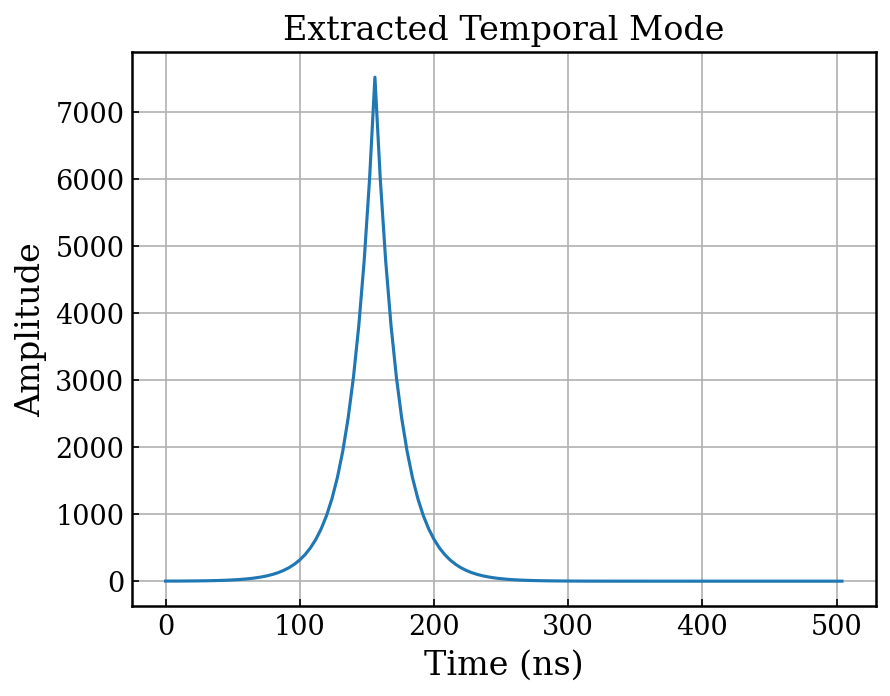

In [6]:
# Extract vacuum data
vacuum = data[-1,0,:,:]

# Define temporal mode from peak in variance
temporal_mode = fs(t, t[39])  # shape (T,)

#temporal_mode /= np.linalg.norm(temporal_mode)

plt.plot(t*1e9, temporal_mode)
plt.title("Extracted Temporal Mode")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [7]:
data.shape

(13, 3, 10000, 127)

In [8]:
for i in range(12):
    print(f'Index: {3*i}, Angle: {15*i} deg')
    state = data[i,0,:,:]
    state_var = state.var(axis=0)/vacuum_var
    plt.plot(t*1e9, state_var, label=f'{15*i} deg')
#plt.plot(t*1e9, temporal_mode, label='Temporal Mode')
#plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

Index: 0, Angle: 0 deg


NameError: name 'vacuum_var' is not defined

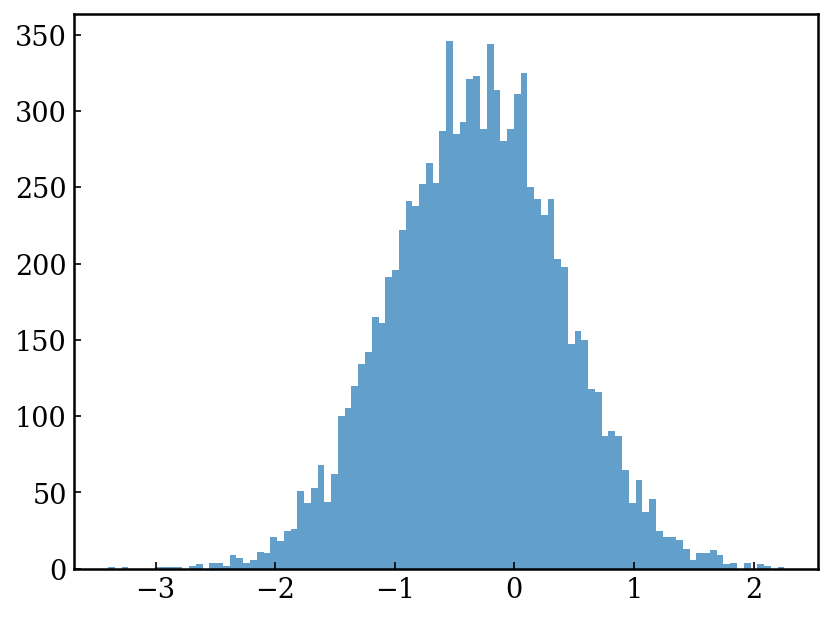

In [7]:
#vacuum_quadratures = np.sum(vacuum*temporal_mode, axis=1)*dt
vacuum_quadratures = vacuum @ temporal_mode * dt
vacuum_mean = np.mean(vacuum_quadratures)
vacuum_std = np.std(vacuum_quadratures)
plt.hist(vacuum_quadratures/(np.sqrt(2)*vacuum_std), bins=100, density=False, alpha=0.7)
plt.show()

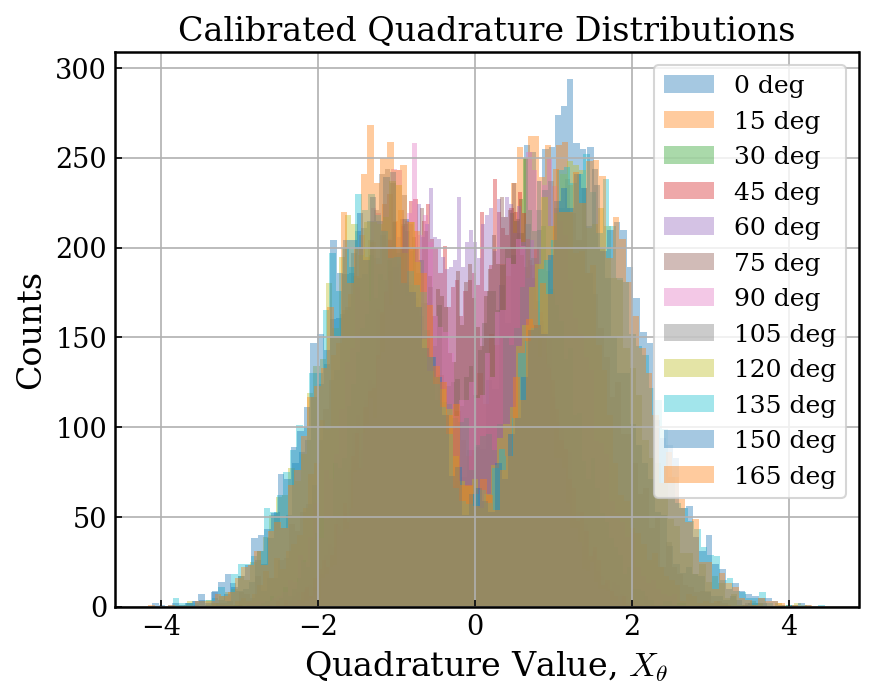

In [8]:
x_values = np.empty((12, 10000))
#theta_values = np.array([])

for i in range(12):
    #print(f'Index: {3*i}, Angle: {15*i} deg')
    state = data[i,0,:,:]
    # Project each trace onto the temporal mode
    quadratures = state @ temporal_mode * dt
    #quadratures = np.sum(state/vacuum_std*temporal_mode, axis=1)*dt
    #quadratures *= 400
    quadratures = (quadratures - vacuum_mean) /(np.sqrt(2)*vacuum_std)
    x_values[i] = quadratures
    #theta_values = np.append(theta_values, np.full_like(quadratures, 15*i))
    #theta_values = np.deg2rad(theta_values)
    plt.hist(quadratures, bins=100, density=False, alpha=0.4, label=f'{15*i} deg')

plt.legend(fontsize=12)
plt.title("Calibrated Quadrature Distributions")
plt.xlabel("Quadrature Value, $X_\\theta$")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

In [9]:
# Make array from 0 to 165 in steps of 15
thetas = np.arange(0, 166, 15)
# Convert to radians
thetas = np.radians(thetas)
thetas.shape

(12,)

In [10]:
x_values.shape

(12, 10000)

In [18]:
from iMLE import iMLE
from WignerDensity import rho_to_Wigner, Wigner_to_rho

In [21]:
np.pi/4

0.7853981633974483

In [36]:
theta0 = np.deg2rad(55)
x0 = -0.1
rho_est = iMLE(thetas-theta0, x_values-x0, N=20, max_iters=400)


 60%|█████▉    | 239/400 [00:06<00:04, 38.18it/s]

Converged in 239 iterations.


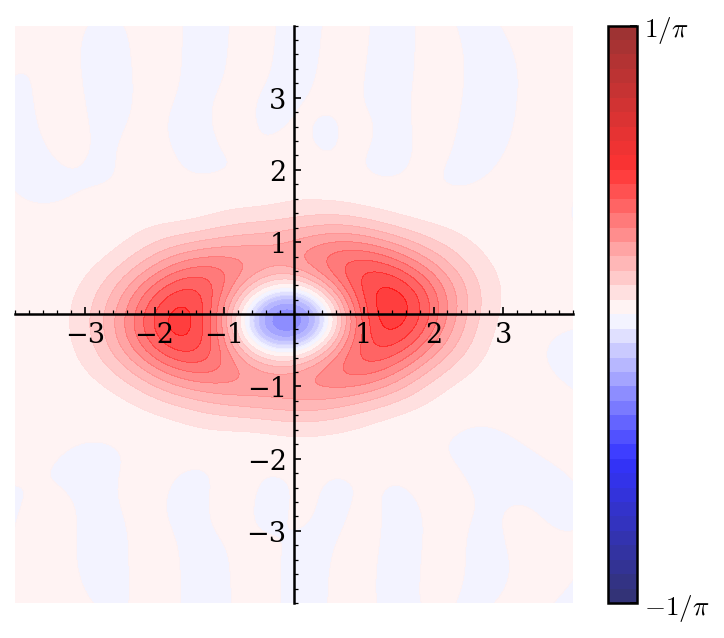

In [37]:
# Make rho_est into a QuTip object to calculate Wigner function
#rho_est_qt = qt.Qobj(rho_est, dims=[[20], [20]])
# Plot Wigner function
xvec = np.linspace(-4, 4, 200)
W = rho_to_Wigner(rho_est, xvec, xvec)
X, Y = np.meshgrid(xvec, xvec)
vmin, vmax = -1/np.pi, 1/np.pi
levels = np.linspace(vmin, vmax, 41)  # force levels across full range

fig, ax = plt.subplots(figsize=(6, 5))
# Filled contours with transparency
contour_filled = ax.contourf(X, Y, W, levels=levels,
                             cmap='seismic', alpha=0.8, vmin=vmin, vmax=vmax)
# Colorbar
cbar = fig.colorbar(contour_filled, ax=ax, ticks=[-1/np.pi, 1/np.pi])
cbar.ax.set_yticklabels([r"$-1/\pi$", r"$1/\pi$"])  # custom tick labels if needed
# Move axes to cross at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# Set x- and y-ticks skipping 0
ax.set_xticks([-3, -2, -1, 1, 2, 3])
ax.set_yticks([-3, -2, -1, 1, 2, 3])
PlotSettings(ax, minimalist=True)
plt.show()


In [13]:
from iMLE import iMLE

In [14]:
rho_est = iMLE(thetas, x_values, N, max_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: only length-1 arrays can be converted to Python scalars

In [69]:
rho_est = mle_reconstruction_binned(thetas, x_values, N=50, n_bins=200)

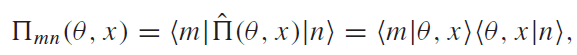
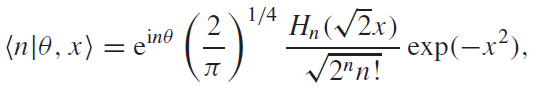

In [70]:
import numpy as np
from scipy.special import hermite, factorial
from numpy import sqrt, pi, exp
import qutip as qt
import numpy as np
from tqdm import tqdm

def Pi_mn(theta, x, N):
    """
    Projection operator in the Fock basis Pi_mn(theta,x)

    Inputs:
        theta: Quadrature phase in radians (float).
        x: Quadrature measurement outcome (float).
        N: Dimension cutoff (int).

    Returns:
        Pi: Projection operator (ndarray, shape (N, N))
    """
    # Compute coefficients ⟨m|theta,x⟩ in Fock basis
    coeffs = np.zeros(N, dtype=np.complex128)
    norm = (1 / (pi**0.25)) * exp(-x**2 / 2)

    for n in range(N):
        Hn = hermite(n)(x)
        coeffs[n] = norm * Hn / sqrt(2**n * factorial(n)) * np.exp(-1j * n * theta)

    # Pi_mn = <m | theta, x> <theta, x | n>
    Pi = np.outer(coeffs, np.conjugate(coeffs))
    return Pi


In [72]:
def bin_homodyne_data(x_values, theta_values, num_bins=100, x_range=(-5, 5)):
    """
    Bins the homodyne data per angle.
    
    Returns:
        binned_x: array of bin centers
        binned_theta: corresponding phase for each bin
        binned_counts: count in each bin
    """
    binned_x = []
    binned_theta = []
    binned_counts = []

    thetas_unique = np.unique(theta_values)

    for theta in thetas_unique:
        x_theta = x_values[theta_values == theta]

        counts, edges = np.histogram(x_theta, bins=num_bins, range=x_range)
        bin_centers = (edges[:-1] + edges[1:]) / 2

        binned_x.extend(bin_centers)
        binned_theta.extend([theta] * len(bin_centers))
        binned_counts.extend(counts)

    return np.array(binned_x), np.array(binned_theta), np.array(binned_counts)

In [73]:
def mle_reconstruction_binned(x_bins, theta_bins, counts, N=10, max_iters=20):
    rho = qt.qeye(N) / N  # initial guess

    for it in tqdm(range(max_iters)):
        R = 0
        for x, theta, c in zip(x_bins, theta_bins, counts):
            if c == 0:
                continue
            Pi = Pi_mn(x, theta, N)
            p = (rho * Pi).tr().real + 1e-12
            R += c * (Pi / p)

        rho_new = R * rho * R
        rho_new = rho_new / rho_new.tr()

        delta = (rho_new - rho).norm()
        rho = rho_new

        if delta < 1e-6:
            print(f"Converged at iteration {it}")
            break

    return rho


In [74]:
# Bin your data
x_bins, theta_bins, counts = bin_homodyne_data(x_values, theta_values, num_bins=200)

# Run MLE
rho_est = mle_reconstruction_binned(x_bins, theta_bins, counts, N=6, max_iters=100)


IndexError: boolean index did not match indexed array along axis 0; size of axis is 12 but size of corresponding boolean axis is 120000

In [63]:
rho_est

array([[ 0.00689066-9.42810545e-20j,  0.00217898-9.84028346e-03j,
        -0.0053032 +6.53627711e-03j, ..., -0.00599598-7.55233120e-03j,
        -0.00039512+2.30307043e-03j, -0.00868554+6.63009709e-03j],
       [ 0.00217898+9.84028346e-03j,  0.01474157-8.70662891e-22j,
        -0.0110112 -5.50638071e-03j, ...,  0.00888913-1.09508416e-02j,
        -0.00341387+1.64023151e-04j, -0.01221475-1.03068988e-02j],
       [-0.0053032 -6.53627711e-03j, -0.0110112 +5.50638071e-03j,
         0.01028158+6.84135315e-19j, ..., -0.00254928+1.15000494e-02j,
         0.00248872-1.39769179e-03j,  0.0129737 +3.13618082e-03j],
       ...,
       [-0.00599598+7.55233120e-03j,  0.00888913+1.09508416e-02j,
        -0.00254928-1.15000494e-02j, ...,  0.013495  -8.16451385e-19j,
        -0.0021804 -2.43710483e-03j,  0.00029106-1.52888133e-02j],
       [-0.00039512-2.30307043e-03j, -0.00341387-1.64023151e-04j,
         0.00248872+1.39769179e-03j, ..., -0.0021804 +2.43710483e-03j,
         0.00079241-1.08421639e-20j

In [65]:
# Make rho_est into a QuTip object to calculate Wigner function
rho_est_qt = qt.Qobj(rho_est, dims=[[50], [50]])


In [66]:
rho_est_qt.shape

(50, 50)

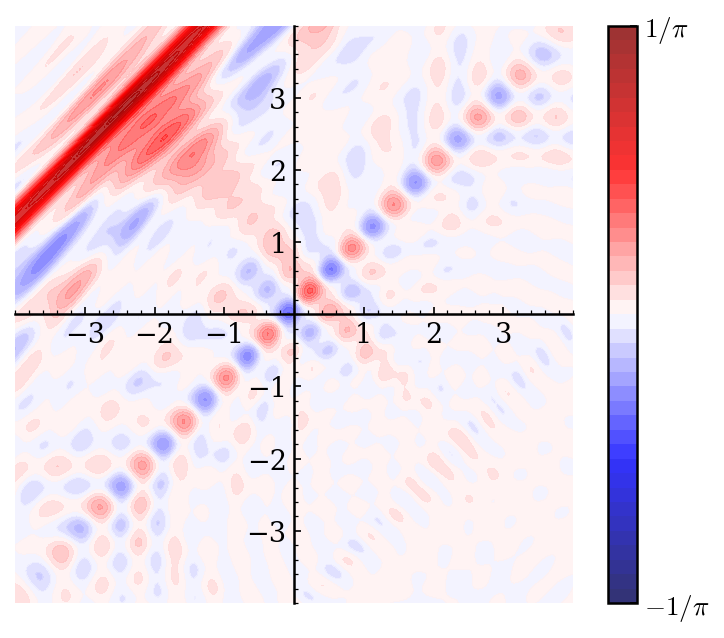

In [67]:
# Plot Wigner function
xvec = np.linspace(-4, 4, 200)
W = qt.wigner(rho_est_qt, xvec, xvec)
X, Y = np.meshgrid(xvec, xvec)
vmin, vmax = -1/np.pi, 1/np.pi
levels = np.linspace(vmin, vmax, 41)  # force levels across full range

fig, ax = plt.subplots(figsize=(6, 5))
# Filled contours with transparency
contour_filled = ax.contourf(X, Y, W, levels=levels,
                             cmap='seismic', alpha=0.8, vmin=vmin, vmax=vmax)
# Colorbar
cbar = fig.colorbar(contour_filled, ax=ax, ticks=[-1/np.pi, 1/np.pi])
cbar.ax.set_yticklabels([r"$-1/\pi$", r"$1/\pi$"])  # custom tick labels if needed
# Move axes to cross at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# Set x- and y-ticks skipping 0
ax.set_xticks([-3, -2, -1, 1, 2, 3])
ax.set_yticks([-3, -2, -1, 1, 2, 3])
PlotSettings(ax, minimalist=True)
plt.show()

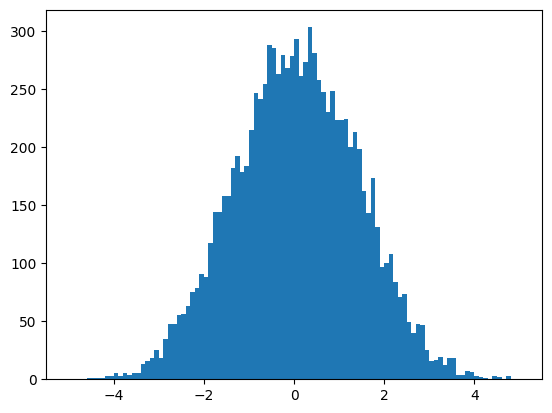

In [217]:
counts, bins = np.histogram(quadratures, bins=100, range=(-5, 5))
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qutip import *

# --- Settings ---
N = 20  # Fock basis cutoff
num_bins = 100  # bins per angle
x_range = (-5, 5)  # quadrature domain
#angles_deg = [0, 30, 60, 90, 120, 150]
#angles_rad = np.deg2rad(angles_deg)

# --- Data ---
data_x = x_values
data_theta = theta_values

# --- Step 1: Bin data and compute histogram per angle ---
binned_data = {}
bin_centers = np.linspace(x_range[0], x_range[1], num_bins)
bin_width = bin_centers[1] - bin_centers[0]

for theta in np.unique(data_theta):
    x_theta = data_x[data_theta == theta]
    hist, _ = np.histogram(x_theta, bins=num_bins, range=x_range)
    binned_data[theta] = hist

# --- Step 2: Precompute eigenstates of x_theta operator ---
projectors = {}     # theta → list of projectors
eigval_tables = {}  # theta → eigenvalues

for theta in np.unique(data_theta):
    a = destroy(N)
    q = (a + a.dag()) / np.sqrt(2)
    p = -1j * (a - a.dag()) / np.sqrt(2)
    x_op = q * np.cos(theta) + p * np.sin(theta)
    eigvals, eigkets = x_op.eigenstates()

    projectors[theta] = [ket * ket.dag() for ket in eigkets]
    eigval_tables[theta] = np.array(eigvals)

# --- Step 3: Utility to get closest projector for a bin center ---
def get_projector(x, theta):
    eigvals = eigval_tables[theta]
    idx = np.argmin(np.abs(eigvals - x))
    return projectors[theta][idx]

# --- Step 4: Parametrize density matrix using Cholesky decomposition ---
def build_rho(params, N):
    # Split real and imaginary parts
    real = params[:N*N].reshape((N, N))
    imag = params[N*N:].reshape((N, N))
    L = Qobj(real + 1j * imag)
    rho = (L.dag() * L).unit()
    return rho

# --- Step 5: Negative log-likelihood with binned data ---
def neg_log_likelihood(params, bin_centers, binned_data, N):
    rho = build_rho(params, N)
    logL = 0
    for theta, hist in binned_data.items():
        for count, x in zip(hist, bin_centers):
            if count == 0:
                continue
            Pi = get_projector(x, theta)
            p = (rho * Pi).tr().real
            p = max(p, 1e-12)
            logL += count * np.log(p)
    return -logL

# --- Step 6: Initial guess ---
L0 = np.eye(N, dtype=complex)
params0 = np.concatenate([L0.real.flatten(), L0.imag.flatten()])

# --- Step 7: Optimize ---
print("Starting optimization...")
result = minimize(
    neg_log_likelihood,
    params0,
    args=(bin_centers, binned_data, N),
    method='BFGS',
    options={'maxiter': 200, 'disp': True}
)

# --- Step 8: Reconstruct density matrix ---
rho_mle = build_rho(result.x, N)


Starting optimization...
         Current function value: 286923.659724
         Iterations: 200
         Function evaluations: 169812
         Gradient evaluations: 212


c:\Users\tbrav\OneDrive - Danmarks Tekniske Universitet\Engineering Physics - MSc\Sem 2\10387 Scientific Computing in Quantum Information Science\Homodyne-Tomograpy\.venv\Lib\site-packages\scipy\optimize\_minimize.py:779: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


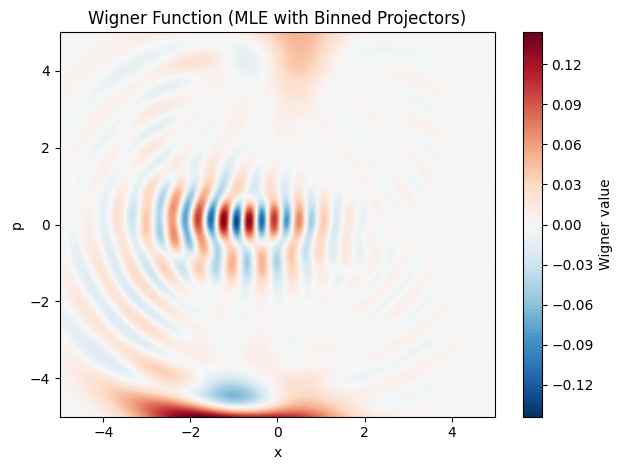

In [96]:
# --- Step 9: Plot Wigner function ---
xvec = np.linspace(-5, 5, 200)
W = wigner(rho_mle, xvec, xvec)

plt.contourf(xvec, xvec, W, 100, cmap='RdBu_r')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Wigner Function (MLE with Binned Projectors)')
plt.colorbar(label='Wigner value')
plt.tight_layout()
plt.show()

In [90]:
# Project each trace onto the temporal mode
quadratures = np.dot(state, temporal_mode)
quadratures.shape

(10000,)

In [91]:
vacuum_proj = np.dot(vacuum, temporal_mode)
vacuum_mean = np.mean(vacuum_proj)
vacuum_std = np.std(vacuum_proj)

# Calibrated signal
quadratures_calibrated = (quadratures - vacuum_mean) / vacuum_std


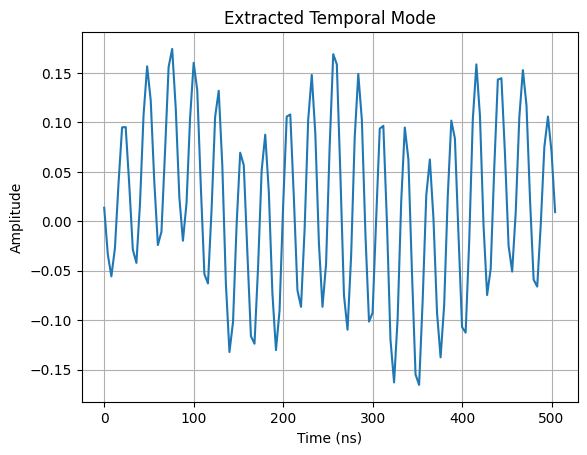

In [92]:
import matplotlib.pyplot as plt

plt.plot(t*1e9, temporal_mode)
plt.title("Extracted Temporal Mode")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


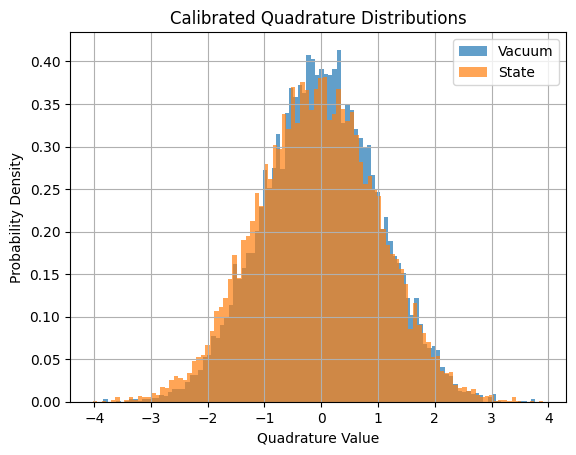

In [97]:
plt.hist((vacuum_proj - vacuum_mean) / vacuum_std, bins=100, density=True, alpha=0.7, label='Vacuum')
plt.hist(quadratures_calibrated, bins=100, density=True, alpha=0.7, label='State')
plt.legend()
plt.title("Calibrated Quadrature Distributions")
plt.xlabel("Quadrature Value")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()


(0.0, 50000000.0)

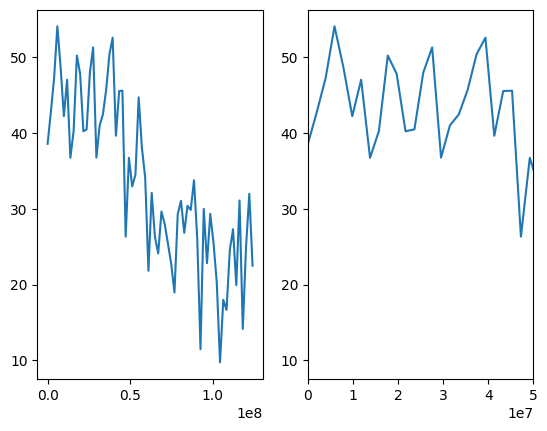

In [66]:
fig, axs = plt.subplots(1, 2)
spec = np.fft.rfft(tora1[0,0,0])
psd = 10*np.log10(np.abs(spec)**2)
axs[0].plot(f, psd)
axs[1].plot(f, psd)
axs[1].set_xlim(0, 50e6)

In [56]:
data

array([[[[-11, -11,  -7, ...,  27,  32,  28],
         [ 10, -10, -22, ...,  18,  21,   9],
         [ 15,  11,  10, ...,   4,  -2,  -8],
         ...,
         [ -8,  -9, -10, ..., -20, -13,  -6],
         [  7,  -9, -19, ...,  -1,  14,  26],
         [-10,  -1,   8, ...,  27,  23,  16]],

        [[  1,  -3,   3, ...,  -8,  -4,  13],
         [ -4, -26, -26, ...,   4,  -5, -15],
         [  4,  21,  16, ...,  -9,  -8, -10],
         ...,
         [-22, -24, -10, ..., -17, -21, -17],
         [-21, -21, -21, ...,  -1,   2,   3],
         [-15,  -9,  -3, ..., -23, -22, -16]],

        [[ -1,  -6,  -9, ...,  16,   9,   1],
         [ 11,  15,  12, ...,  25,  23,  16],
         [  8,  19,  21, ..., -14, -19, -13],
         ...,
         [ 21,   8,  -1, ...,  15,  18,  19],
         [-29, -33, -36, ...,  -3,  12,  17],
         [ 10,  -5, -15, ...,   4,  16,  19]],

        ...,

        [[ -4,  19,  29, ..., -12,  -7, -15],
         [  4,   8,  -5, ...,   5,   9,  14],
         [  7, -12

In [55]:
cat1.shape

(3, 39, 10000, 127)

In [25]:
datasets = [f'cat{i}' for i in range(1, 3)] + [f'tora{i}' for i in range(1, 27)]
datasets

['cat1',
 'cat2',
 'tora1',
 'tora2',
 'tora3',
 'tora4',
 'tora5',
 'tora6',
 'tora7',
 'tora8',
 'tora9',
 'tora10',
 'tora11',
 'tora12',
 'tora13',
 'tora14',
 'tora15',
 'tora16',
 'tora17',
 'tora18',
 'tora19',
 'tora20',
 'tora21',
 'tora22',
 'tora23',
 'tora24',
 'tora25',
 'tora26']

In [28]:
def get_file_list(date, dataset):
    folder = os.path.join(data_folder, date, dataset)
    fns = sorted(os.listdir(folder))
    fns = [os.path.join(folder, fn) for fn in fns]
    return fns

files = {ds:{dat:get_file_list(dat, ds) for dat in dates} for ds in datasets}

FileNotFoundError: [WinError 3] Den angivne sti blev ikke fundet: 'C:\\Users\\tbrav\\OneDrive\\Skrivebord\\data-tora\\091028\\cat2'